# Face Detection with MediaPipe Tasks

This notebook shows you how to use the MediaPipe Tasks Python API to detect faces in images.

## Preparation

Let's start with installing MediaPipe.

Then download an off-the-shelf model. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_detector#models) for more face detection models that you can use.

## Visualization utilities

To better demonstrate the Face Detector API, we have created a set of visualization tools that will be used in this colab. These will draw a bounding box around detected faces, as well as markers over certain detected points on the faces.

In [1]:
from typing import Tuple, Union
import json
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from math import dist
from numpy import arccos, array
from numpy.linalg import norm

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


# Checks if the float value is between 0 and 1.
def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                  math.isclose(1, value))

def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
    """Converts normalized value pair to pixel coordinates."""

    if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
        return None
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)
    return x_px, y_px


def visualize(
    image,
    detection_result
) -> np.ndarray:
    """Draws bounding boxes and keypoints on the input image and return it.
    Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
    Returns:
    Image with bounding boxes.
    """
    annotated_image = image.copy()
    height, width, _ = image.shape

    for detection in detection_result.detections:
    # Draw bounding_box
        bbox = detection.bounding_box
        start_point = bbox.origin_x, bbox.origin_y
        end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
        cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
        keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
        color, thickness, radius = (0, 255, 0), 2, 2
        cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

    return annotated_image

## Download test image

To demonstrate Face Detection, you can download a sample image using the following code. Credits: https://pixabay.com/photos/brother-sister-girl-family-boy-977170/

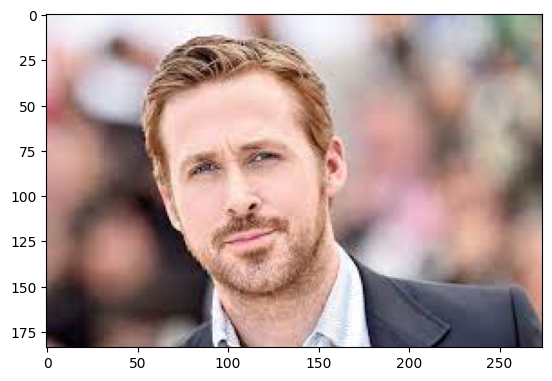

In [2]:
IMAGE_FILE = 'imgs/images.jpg'

import cv2
source_img = cv2.imread(IMAGE_FILE)
source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
plt.imshow(source_img)
plt.show()

Optionally, you can upload your own image from your computer. To do this, uncomment the following code cell.

## Running inference and visualizing the results

The final step is to run face detection on your selected image. This involves creating your FaceDetector object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

You can check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/face_detector/python) to learn more about configuration options that this solution supports.

I0000 00:00:1713096235.356759    3035 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:84) egl_initializedUnable to initialize EGL
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


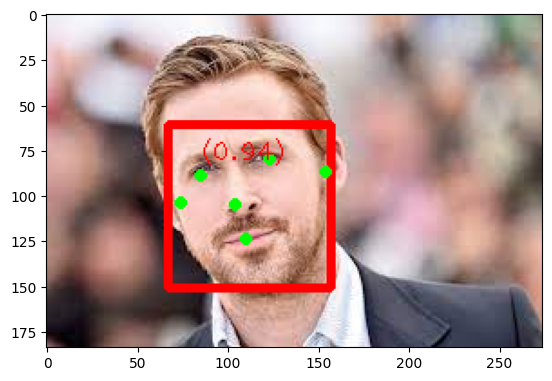

In [3]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.components.containers.keypoint import NormalizedKeypoint

# STEP 2: Create an FaceDetector object.
base_options = python.BaseOptions(model_asset_path='models/detector.tflite')
options = vision.FaceDetectorOptions(base_options=base_options)
detector = vision.FaceDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect faces in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.cvtColor(rgb_annotated_image, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
#0 - левый глаз
#1 - правый глаз
#2 - нос
#3  - рот
#4 - левое ухо
#5 - правое ухо
keypoints = [det.keypoints for det in detection_result.detections]

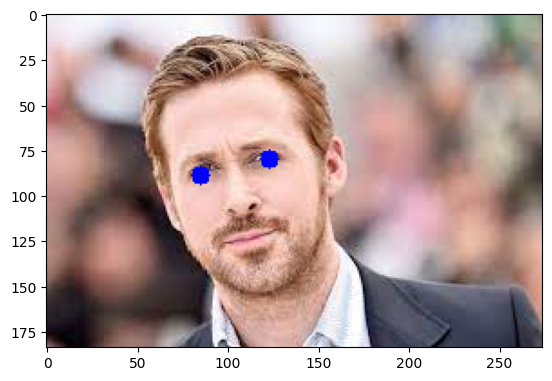

In [5]:
keypoint = keypoints[0][0]
keypoint2 = keypoints[0][1]

height, width, _ = source_img.shape
keypoint_px2 = np.array(_normalized_to_pixel_coordinates(keypoint2.x, keypoint2.y,
                                             width, height))

keypoint_px = np.array(_normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                             width, height))

image = source_img.copy()
image = cv2.circle(image, keypoint_px, radius=5, color=(0, 0, 255), thickness=-1)
image = cv2.circle(image, keypoint_px2, radius=5, color=(0, 0, 255), thickness=-1)
plt.imshow(image)

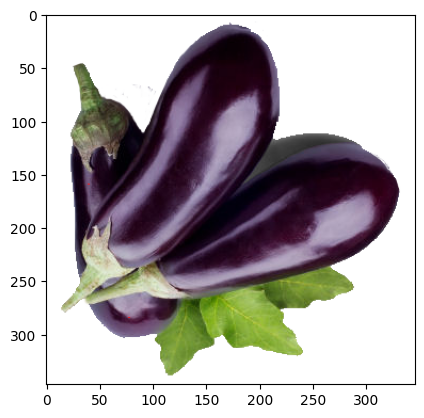

In [6]:
dick_path = "overlay/baklajan_rot.png"
dick = cv2.imread(dick_path)
dick = cv2.cvtColor(dick, cv2.COLOR_BGR2RGB)
plt.imshow(dick)

In [7]:
front_height, front_width, _ = dick.shape

@dataclass
class Eyes:
    left: np.array
    right: np.array

In [8]:
with open('overlay/project-13-at-2024-04-14-11-15-806736ef.json', 'r', encoding='utf-8') as f:
    labeling_eggs = json.load(f)
result_eggs = dict()
for eggs in labeling_eggs:
    img = 'overlay/'+eggs['img'].split('-')[-1]
    result_egg = dict()
    for side in eggs['kp-1']:
        side_name = side['keypointlabels'][0]
        result_egg[side_name] = NormalizedKeypoint(side['x']/100, side['y']/100)
    result_eggs[img] = result_egg

In [9]:
result_eggs

{'overlay/baklajan_rot.png': {'left': NormalizedKeypoint(x=0.24960000000000002, y=0.7878787878787878, label=None, score=None),
  'right': NormalizedKeypoint(x=0.1568, y=0.2966507177033493, label=None, score=None)}}

In [10]:
back_keys_n = keypoints[0][:2]
#front_keys_n = [NormalizedKeypoint(0.7745664739884393,0.18443804034582133), NormalizedKeypoint(0.8786127167630057,0.5504322766570605)]
front_keys_n = [result_eggs[dick_path]['left'], result_eggs[dick_path]['right']]

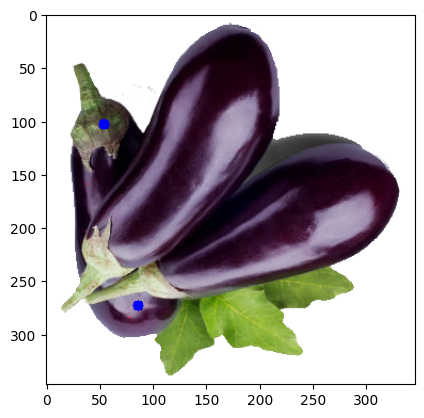

In [11]:
_dick = dick.copy()
_dick = cv2.circle(_dick, (round(front_keys_n[0].x*front_width),round(front_keys_n[0].y*front_height)), radius=5, color=(0, 0, 255), thickness=-1)
_dick = cv2.circle(_dick, (round(front_keys_n[1].x*front_width),round(front_keys_n[1].y*front_height)), radius=5, color=(0, 0, 255), thickness=-1)
plt.imshow(_dick)

In [12]:
back_eyes = Eyes(np.array(_normalized_to_pixel_coordinates(back_keys_n[0].x, back_keys_n[0].y, width, height)),
                 np.array(_normalized_to_pixel_coordinates(back_keys_n[1].x, back_keys_n[1].y, width, height)))

front_eyes = Eyes(np.array(_normalized_to_pixel_coordinates(front_keys_n[0].x, front_keys_n[0].y, front_width, front_height)),
                 np.array(_normalized_to_pixel_coordinates(front_keys_n[1].x, front_keys_n[1].y, front_width, front_height)))

In [13]:
def get_theta(v, w):
    sign = np.sign(v[0]*w[1] - w[0]*v[1])
    return sign*arccos(v.dot(w)/(norm(v)*norm(w))) * 57.29577951308

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    image_center = int(image_center[0]), int(image_center[1])
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255,255,255))
    return result, np.array(image_center)


def rotate_point(point, center, angle):
    ox, oy = center
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) + math.sin(angle) * (py - oy)
    qy = oy - math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return np.array([qx, qy])

In [14]:
def preprocess_dick(dick, back_eyes, front_eyes):
    
    front_height, front_width, _ = dick.shape
    back_eye_vector = back_eyes.right - back_eyes.left
    front_eye_vector = front_eyes.right - front_eyes.left
    
    angle_of_rotation = get_theta(back_eye_vector, front_eye_vector)
    rotated_dick, image_center = rotate_image(dick, angle_of_rotation)
    
    dist_back = dist(back_eyes.left, back_eyes.right)
    dist_front = dist(front_eyes.left, front_eyes.right)
    resize_coef = dist_back / dist_front
    
    new_width = round(front_width * resize_coef)
    new_height = round(front_height * resize_coef)
    resize_rotated_dick = cv2.resize(rotated_dick, (new_width, new_height))
    
    rotate_left = rotate_point(front_eyes.left*resize_coef, image_center*resize_coef, angle_of_rotation/57.29577951308)
    rotate_right = rotate_point(front_eyes.right*resize_coef, image_center*resize_coef, angle_of_rotation/57.29577951308)
    
    rotate_eyes = Eyes(np.around(rotate_left).astype(int), np.around(rotate_right).astype(int))
    
    return resize_rotated_dick, rotate_eyes

In [15]:
ready_dick, new_eyes = preprocess_dick(dick, back_eyes, front_eyes)

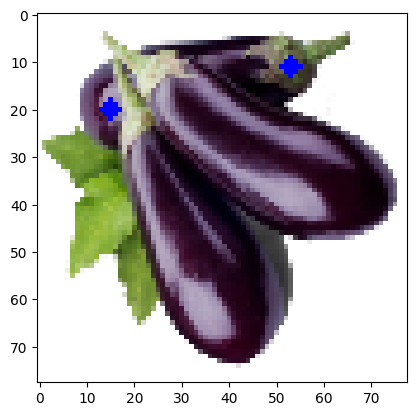

In [16]:
_ready_dick = ready_dick.copy()
_ready_dick = cv2.circle(_ready_dick, new_eyes.left, radius=2, color=(0, 0, 255), thickness=-1)
_ready_dick = cv2.circle(_ready_dick, new_eyes.right, radius=2, color=(0, 0, 255), thickness=-1)
plt.imshow(_ready_dick)

In [23]:
def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """Overlay `img_overlay` onto `img` at (x, y) and blend using `alpha_mask`.

    `alpha_mask` must have same HxW as `img_overlay` and values in range [0, 1].
    """
    # Image ranges
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Overlay ranges
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Exit if nothing to do
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined ranges
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop

In [27]:
alpha_mask = (ready_dick.sum(axis=2) / 765) < 0.9

source_preproc_img = source_img.copy()
overlay_image_alpha(source_preproc_img, ready_dick, start_point[0], start_point[1], alpha_mask)

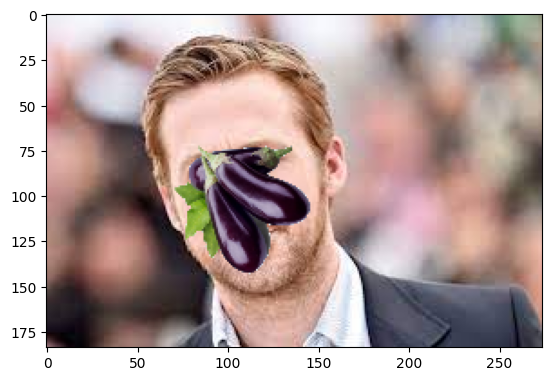

In [28]:
plt.imshow(source_preproc_img)